# KMeans Clustering

In [1]:
%matplotlib inline

import datacube
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr, create_cfmask_clean_mask
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, ls8_unpack_qa
from utils.data_cube_utilities.dc_clustering import kmeans_cluster_dataset, plot_kmeans_next_to_mosaic

from datetime import datetime
import xarray as xr
import gdal
import numpy as np

dc = datacube.Datacube(config='/home/localuser/.datacube.conf', app='kmeans_clustering')
lat_range = (10.9, 11.00)
lon_range = (107.8, 107.9)
time_range = (datetime(2015,1,1), datetime(2017,1,1))

In [2]:
product = "ls8_lasrc_vietnam"
platform = "LANDSAT_8"

In [3]:
product_details = dc.list_products()[dc.list_products().name == product]
geographic_chunks = create_geographic_chunks(latitude=lat_range, longitude=lon_range, geographic_chunk_size=.05)

# Chunked Loading and Compositing of Landsat 8 Imagery

In [4]:
measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']
product_chunks = []

for index, chunk in enumerate(geographic_chunks):
    data = dc.load(product=product, time=time_range, 
                   lon=chunk['longitude'], lat=chunk['latitude'], 
                   measurements=measurements)

    clear_xarray  = ls8_unpack_qa(data.pixel_qa, "clear")
    water_xarray  = ls8_unpack_qa(data.pixel_qa, "water")
    
    clean_mask = np.logical_or(clear_xarray.values.astype(bool),
                               water_xarray.values.astype(bool))
    product_chunks.append(create_median_mosaic(data, clean_mask = clean_mask))

final_mosaic = combine_geographic_chunks(product_chunks)

write_geotiff_from_xr("ls8_median_mosaic.tif", final_mosaic, measurements, no_data=-9999)

In [5]:
from dc_notebook_utilities import rgb

In [6]:
final_mosaic

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372)
Coordinates:
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 ...
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 107.8 107.8 107.8 ...
Data variables:
    blue       (latitude, longitude) float64 209.0 210.0 194.0 174.0 198.5 ...
    green      (latitude, longitude) float64 419.0 420.0 409.5 364.0 423.0 ...
    red        (latitude, longitude) float64 235.0 249.0 220.0 205.0 259.0 ...
    nir        (latitude, longitude) float64 3.39e+03 3.176e+03 2.954e+03 ...
    swir1      (latitude, longitude) float64 1.526e+03 1.502e+03 1.464e+03 ...
    swir2      (latitude, longitude) float64 580.0 596.0 549.5 502.0 587.5 ...
    pixel_qa   (latitude, longitude) float64 322.0 322.0 322.0 322.0 322.0 ...

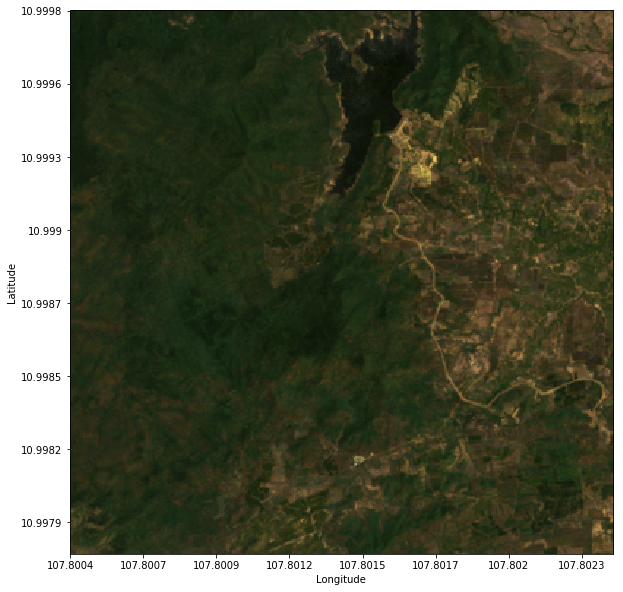

In [7]:
rgb(final_mosaic)

# Computing KMeans  

In [14]:
classification_2 = kmeans_cluster_dataset(final_mosaic, n_clusters=2)
classification_3 = kmeans_cluster_dataset(final_mosaic, n_clusters=3)
classification_4 = kmeans_cluster_dataset(final_mosaic, n_clusters=4)
classification_8 = kmeans_cluster_dataset(final_mosaic, n_clusters=8)
classification_12 = kmeans_cluster_dataset(final_mosaic, n_clusters=12)

write_geotiff_from_xr("output/geotiffs/landsat8/ls8_cluster2.tif", classification_4, ['classification'], no_data=-9999)
write_geotiff_from_xr("output/geotiffs/landsat8/ls8_cluster3.tif", classification_8, ['classification'], no_data=-9999)
write_geotiff_from_xr("output/geotiffs/landsat8/ls8_cluster4.tif", classification_4, ['classification'], no_data=-9999)
write_geotiff_from_xr("output/geotiffs/landsat8/ls8_cluster8.tif", classification_8, ['classification'], no_data=-9999)
write_geotiff_from_xr("output/geotiffs/landsat8/ls8_cluster12.tif", classification_12, ['classification'], no_data=-9999)

## Plot Results 

In [15]:
import matplotlib.pyplot as plt 

### K = 2 

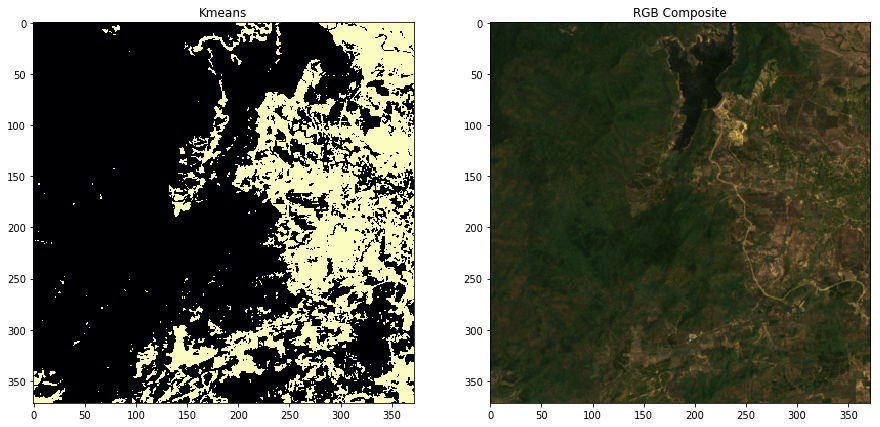

In [16]:
plot_kmeans_next_to_mosaic(classification_2.classification,final_mosaic)

### K = 4

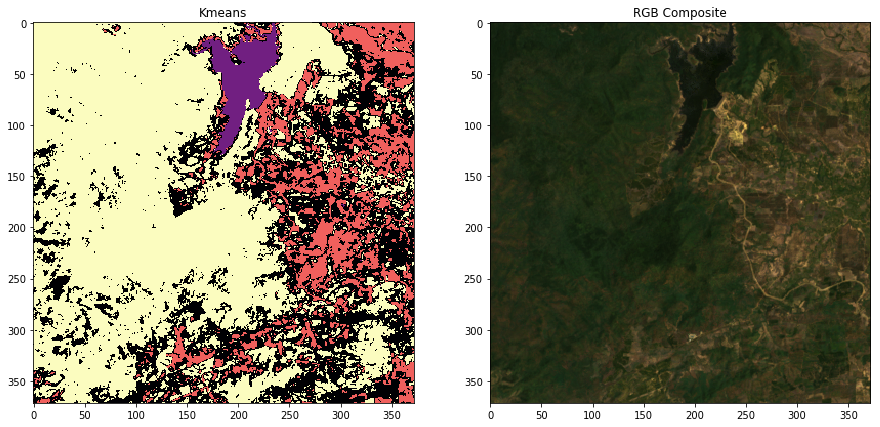

In [17]:
plot_kmeans_next_to_mosaic(classification_4.classification,final_mosaic)

### K = 8

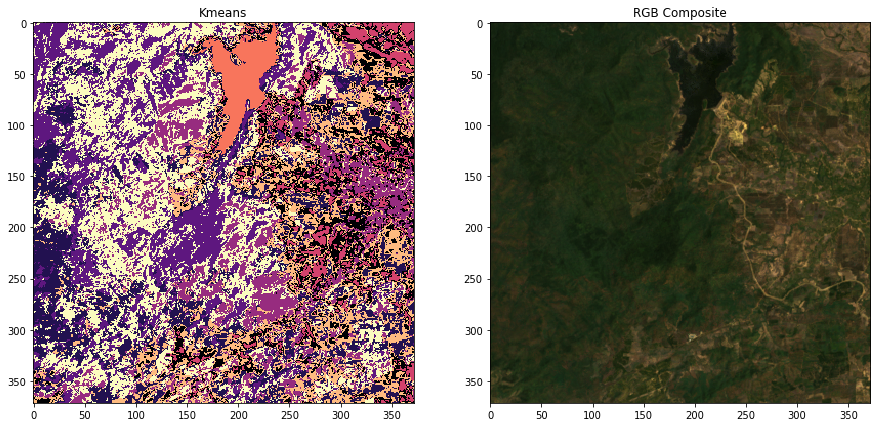

In [18]:
plot_kmeans_next_to_mosaic(classification_8.classification,final_mosaic)

### K = 12

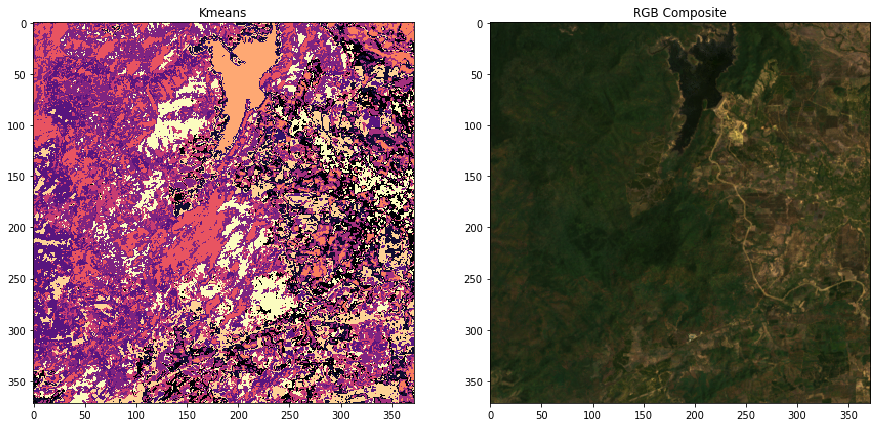

In [19]:
plot_kmeans_next_to_mosaic(classification_12.classification,final_mosaic)